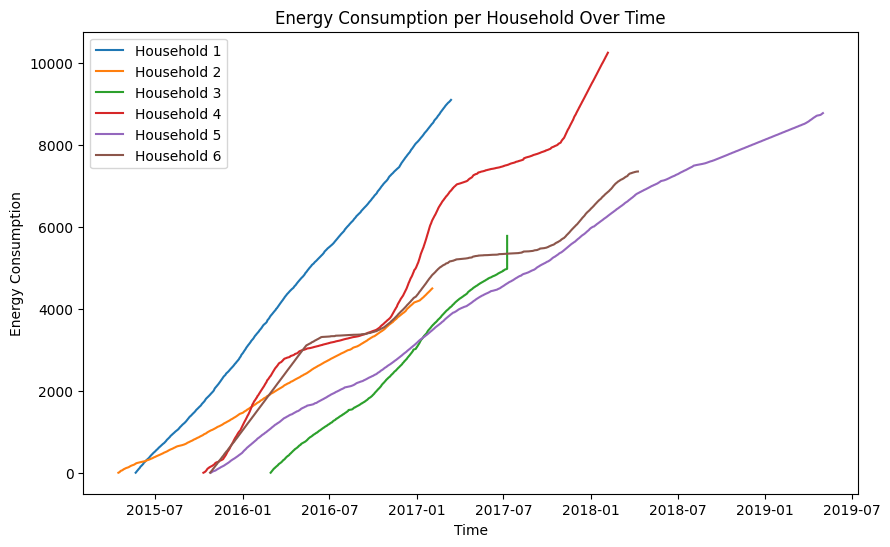

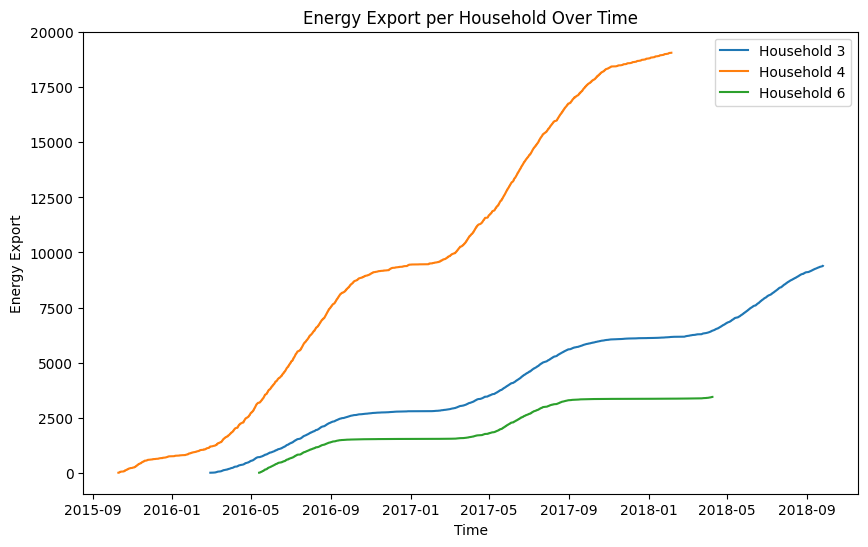

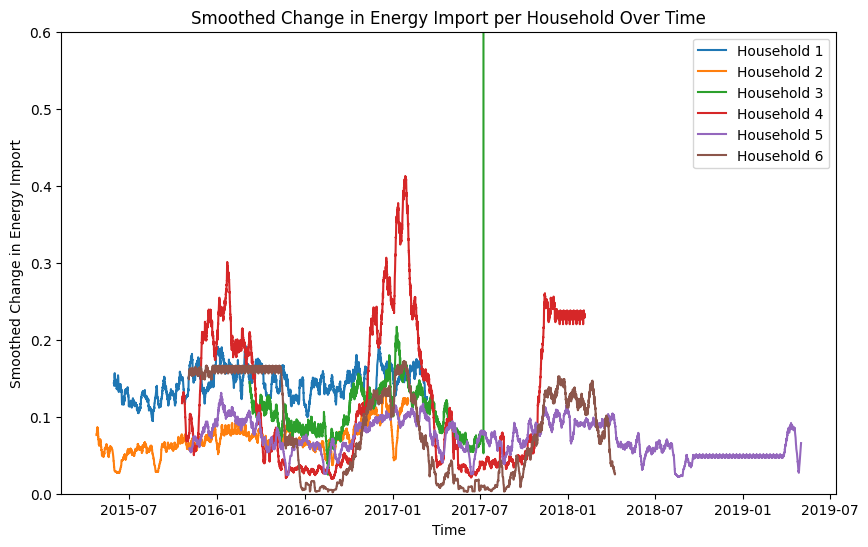

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('a.csv')

# Convert the 'utc_timestamp' column to datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# List of households
households = [1, 2, 3, 4, 5, 6]

# Plot energy consumption over time for each household
plt.figure(figsize=(10,6))

for i in households:
    # Plot energy consumption over time for this household
    plt.plot(df['utc_timestamp'], df[f'DE_KN_residential{i}_grid_import'], label=f'Household {i}')

plt.title('Energy Consumption per Household Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Plot energy export over time for each household
plt.figure(figsize=(10,6))

for i in households:
    # Check if the household has a 'grid_export' column
    if f'DE_KN_residential{i}_grid_export' in df.columns:
        # Plot energy export over time for this household
        plt.plot(df['utc_timestamp'], df[f'DE_KN_residential{i}_grid_export'], label=f'Household {i}')

plt.title('Energy Export per Household Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Export')
plt.legend()
plt.show()





window = 800  # Set the size of the rolling window

plt.figure(figsize=(10,6))

for i in households:
    # Check if the household has a 'grid_import' column
    if f'DE_KN_residential{i}_grid_import' in df.columns:
        # Calculate the change in energy import for this household
        df[f'DE_KN_residential{i}_grid_import_change'] = df[f'DE_KN_residential{i}_grid_import'].diff()
        
        # Apply a rolling mean to the change in energy import
        df[f'DE_KN_residential{i}_grid_import_change_smooth'] = df[f'DE_KN_residential{i}_grid_import_change'].rolling(window).mean()
        
        # Plot the smoothed change in energy import over time for this household
        plt.plot(df['utc_timestamp'], df[f'DE_KN_residential{i}_grid_import_change_smooth'], label=f'Household {i}')

plt.title('Smoothed Change in Energy Import per Household Over Time')
plt.xlabel('Time')
plt.ylim([0, 0.6])  # Set the limits of the y-axis
plt.ylabel('Smoothed Change in Energy Import')
plt.legend()
plt.show()





In [3]:
import pandas as pd

# Load the data
df = pd.read_csv('a.csv')

# Select 'DE_KN_residential4_grid_import' and 'export' columns
df = df[['utc_timestamp', 'DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export']]

# Remove rows where 'DE_KN_residential4_grid_import' or 'export' is NaN
df = df.dropna(subset=['DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export'])

# Export to a new CSV file
df.to_csv('residential4_grid_import_export.csv', index=False)

In [4]:
import pandas as pd

# Load the data
df = pd.read_csv('a.csv')

# Select 'DE_KN_residential1_grid_import' to 'DE_KN_residential6_grid_import' columns
residential_cols = [f'DE_KN_residential{i}_grid_import' for i in range(1, 7)]
df = df[['utc_timestamp'] + residential_cols]

# Remove rows where all residential columns are NaN
df = df.dropna(subset=residential_cols, how='all')

# Export to a new CSV file
df.to_csv('residential1_to_6_grid_import.csv', index=False)

In [2]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from river.feature_selection import SelectKBest
from river.metrics import Accuracy
# Load the data
df = pd.read_csv('residential4_grid_import_export_weather_fixed_timestamps.csv')

# Convert the 'utc_timestamp' column to datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Extract day of the week and hour of the day
df['day_of_week'] = df['utc_timestamp'].dt.dayofweek
df['hour_of_day'] = df['utc_timestamp'].dt.hour

# Define the features and the target
features = ['hour_of_day', 'DE_KN_residential4_grid_export', 'temp', 
            'season_Winter', 'season_Spring', 'season_Summer', 'season_Autumn',
            'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
            'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 
            'day_of_week_Sunday', 'holiday']
target = 'DE_KN_residential4_grid_import'

# Create a model
model = compose.Pipeline(
    #SelectKBest(Accuracy(), k=10),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)
# Define a metric
metric = metrics.MAE()

# Iterate over the data and update the model and the metric
for xi, yi in stream.iter_pandas(df[features], df[target]):
    y_pred = model.predict_one(xi) if model else None
    model.learn_one(xi, yi)
    if y_pred is not None:
        metric.update(yi, y_pred)

print(f'MAE: {metric.get()}')

MAE: 14188591097.617062
